### Copyright (C) Infineon Technologies AG 2025
 
Copyright (c) 2025, Infineon Technologies AG, or an affiliate of Infineon Technologies AG. All rights reserved.
This software, associated documentation and materials ("Software") is owned by Infineon Technologies AG or one of its affiliates ("Infineon") and is protected by and subject to worldwide patent protection, worldwide copyright laws, and international treaty provisions. Therefore, you may use this Software only as provided in the license agreement accompanying the software package from which you obtained this Software. If no license agreement applies, then any use, reproduction, modification, translation, or compilation of this Software is prohibited without the express written permission of Infineon.

Disclaimer: UNLESS OTHERWISE EXPRESSLY AGREED WITH INFINEON, THIS SOFTWARE IS PROVIDED AS-IS, WITH NO WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ALL WARRANTIES OF NON-INFRINGEMENT OF THIRD-PARTY RIGHTS AND IMPLIED WARRANTIES SUCH AS WARRANTIES OF FITNESS FOR A SPECIFIC USE/PURPOSE OR MERCHANTABILITY. Infineon reserves the right to make changes to the Software without notice. You are responsible for properly designing, programming, and testing the functionality and safety of your intended application of the Software, as well as complying with any legal requirements related to its use. Infineon does not guarantee that the Software will be free from intrusion, data theft or loss, or other breaches ("Security Breaches"), and Infineon shall have no liability arising out of any Security Breaches. Unless otherwise explicitly approved by Infineon, the Software may not be used in any application where a failure of the Product or any consequences of the use thereof can reasonably be expected to result in personal injury.

### Notebook Structure

1. **MobileNet for Traffic Object Classification**: Generation of the Model 
2. **Compiling the Model for AURIX&trade; Microcontrollers**

# MobileNet for Traffic Object Classification

In this notebook we will adapt the MobileNet so that typical traffic objects such as bikes and cars will be classified. Firstly, we will import the MobileNetV3-small with pretrained weights. Next, we will adapt the model so that only traffic-related classes will be classified. This will not only reduce the required storage space for the model but also maximize its accuracy. Finally, we will generate the code that can later be deployed on the AURIX&trade; TC4x.

## Preparing the Model

Importing all required modules and packages.

In [1]:
import sys
import os

from torchsummary import summary
import modelling_helper as mh

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from CentralScripts.python_flask_client import CallTools
import CentralScripts.helper_functions as cs

device = cs.get_device()

Loading the MobileNetV3-small [1]. It's pretrained for 1000 classes using the ImageNet1K data set [2]. Since for traffic object classification not all the classes are relevant. The model will be adapted.

In [2]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

weights = MobileNet_V3_Small_Weights.DEFAULT
model_original = mobilenet_v3_small(weights=weights)

Importing the traffic_classes.json file which contains all the indices of the MobileNetV3 which are relevant for traffic.

In [3]:
classes = mh.get_classes_json("traffic_classes.json")

Fetching some data for testing from kagglehub (Sautkin data set [3]). Plotting some random input.

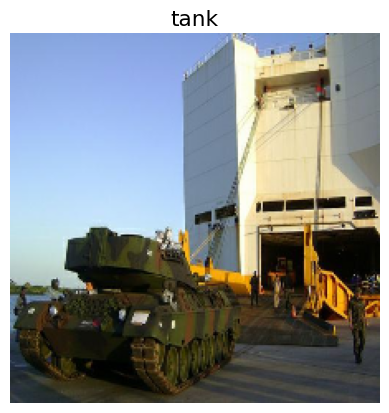

In [4]:
folder_path = mh.get_data()
_, input_size = mh.get_random_input(folder_path, classes, is_plot=True)

Adapting the model so that it only represents the traffic classes. For this, all the other classes will be removed.

In [5]:
model_name = "traffic_mobilenet"
model = mh.get_model_indices(model_original, classes)
summary(model, input_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

Choosing random input which can later be tested on the hardware. Running inference on input data to get some matching output data.

In [6]:
input_target, input_size = mh.get_random_input(folder_path, classes)
output_target, predicted_class = mh.get_predicted_class(input_target, model, classes)

Predicting the class: traffic_light



Saving model, input and output data.

In [7]:
cs.save_all(model_name, input_target, output_target, model, origin="torch")

Directory already exists: out/traffic_mobilenet/test_traffic_mobilenet
Model loaded from out/traffic_mobilenet/test_traffic_mobilenet/model.onnx


Testing the model performance by presenting the prediction of a few random images from the data set.

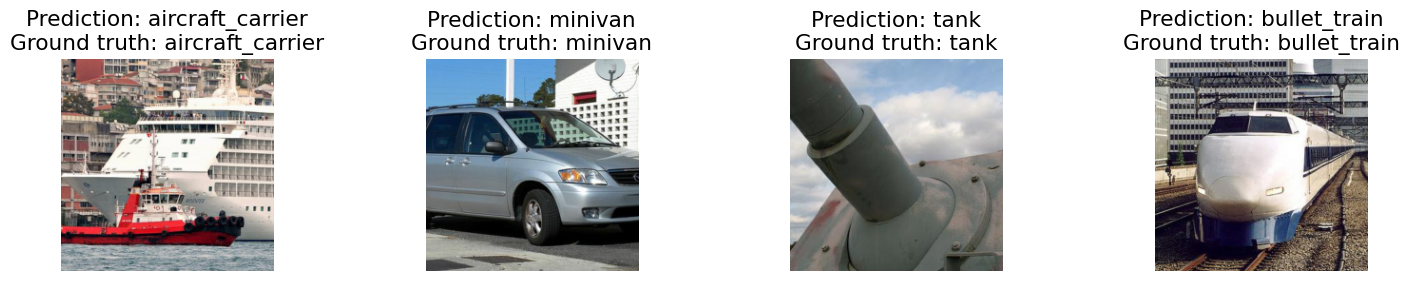

In [8]:
mh.calculate_predictions_and_plot(model, folder_path, classes)

Testing the model for validation by calculating the confusion matrix.

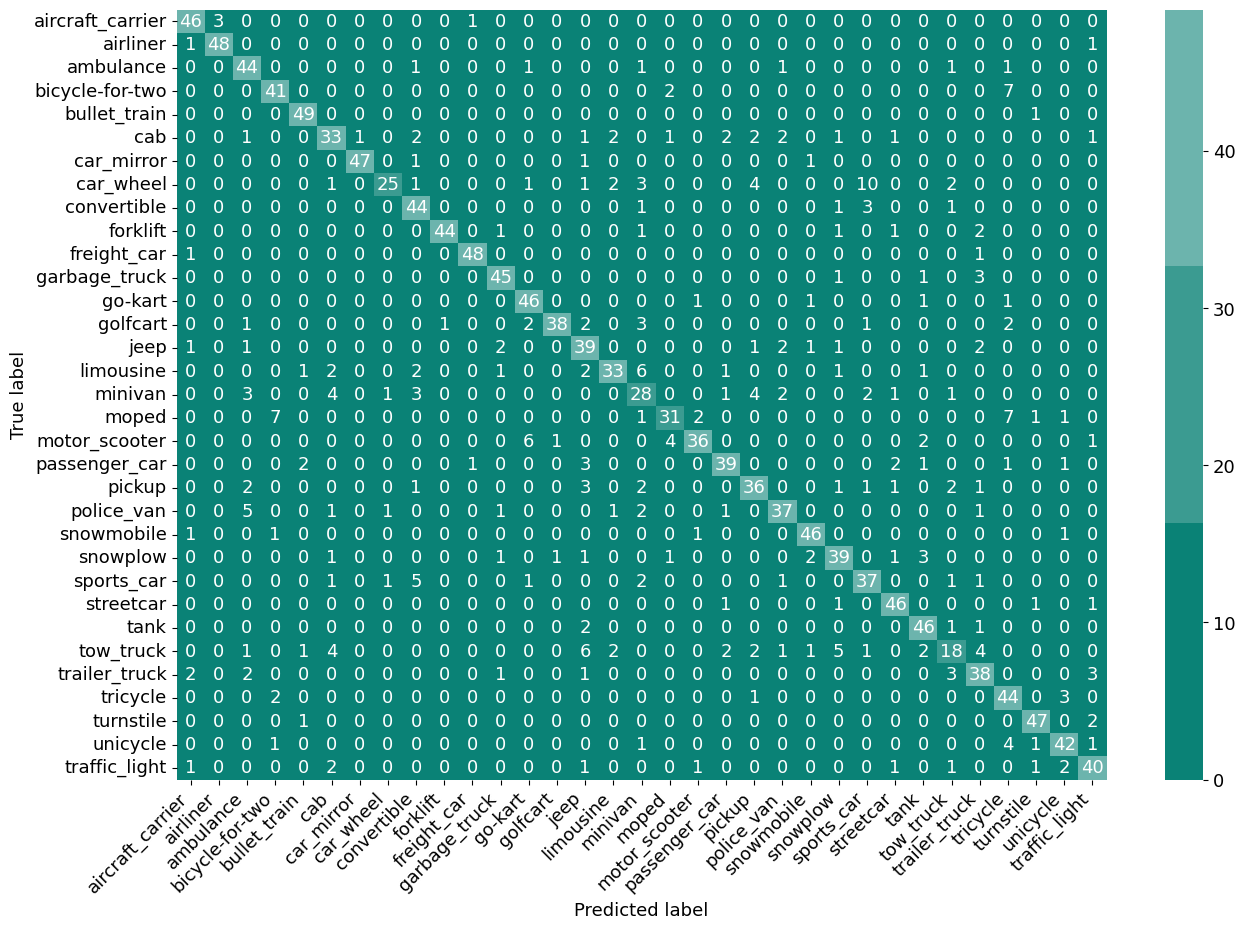

In [9]:
mh.calculate_confusion_matrix(folder_path, model, device, classes)

## Compiling the Model for AURIX&trade; Microcontrollers

For the compilation, we have to prepare a Docker container which includes all the required tools for compilation. In this section, we will set up the container and make sure that it's available. 

In [10]:
cs.ensure_docker_container()

Docker container 'unruffled_galois' (from image 'aurix_ai_tools:V1.0.1.TriCore') is running at http://localhost:8080/convert


Compiling the model for two different targets from the AURIX&trade; microcontroller family: TriCore TC3x and TC4x.

In [14]:
model_folder, onnx_model_file = cs.get_output_paths(model_name)

for target in ["TC3", "TC4"]:
    tool = CallTools(
        folder=model_folder, url="http://localhost:8080/convert", target=target
    )
    tool.convert_model()

Target folder out/traffic_mobilenet/test_traffic_mobilenet/TC3 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}
Target folder out/traffic_mobilenet/test_traffic_mobilenet/TC4 already exists
{'c_file.c': True, 'model_conversion.log': True, 'out.elf': True, 'testgen.c': True}


Comparing the run time of the layers using AURIX&trade; TC3x and TC4x.

Found .log file in TC3 folder: model_conversion.log
Found .log file in TC4 folder: model_conversion.log


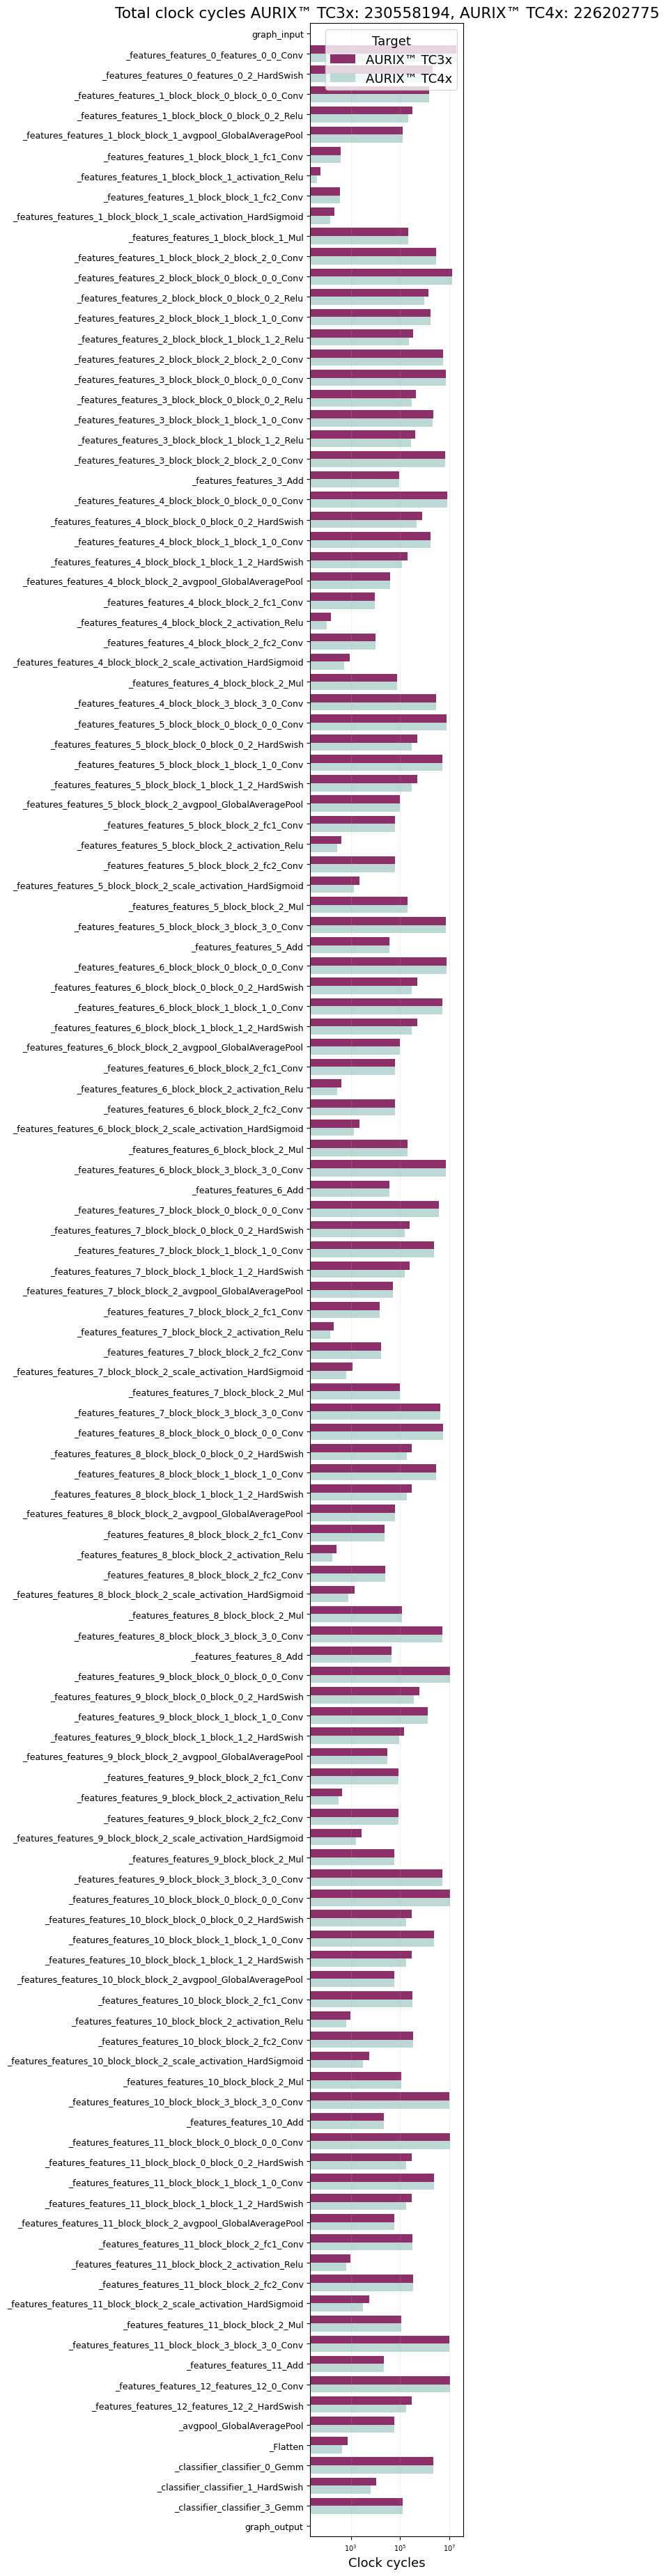

In [15]:
cs.plot_execution_timing(model_name, is_small_font=True)

[1]: Howard, A. et al. (2019). "Searching for MobileNetV3.", ICCV.<br>
[2]: Russakovsky, O. et al. (2015). "ImageNet Large Scale Visual Recognition Challenge", IJCV<br>
[3]: Sautkin data set, [Link to Kaggle](https://www.kaggle.com/datasets/sautkin/imagenet1kvalid)